### Kenneth Huang     kennethhuang@ucsb.edu
# Analysis for experiment 1. Can be used for other experiments but may not perform well <br>
### This program: <br>

- 1) Reads CSV file from Mac os desktop, merges entries on time 
- 2) Cleans and smooths the data using a savgol filter
- 3) Fits a dampened sine wave eq. to all of the data; outputs metrics
- 4) Partionings the dataset into periods by extracting the indices of every 2 local minimums
- 5) Fits a dampened sine wave eq. to each of these periods; outputs metrics
- 6) Plots periodic fits onto each period in the data
- 7) Displays a summary of metrics across all 5 experiments (ran by me)

In [275]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import os
from scipy.optimize import curve_fit
from scipy.stats import norm
import seaborn as sns
from scipy import optimize
import math
from scipy import signal

In [262]:
exp = input("Input the number corresponding to the experiment you wish to analyze: ")
file_path = 'Exp'+ str(exp) + '.csv'
data = pd.read_csv(os.path.expanduser("~/Desktop/exp/" + file_path))

Input the number corresponding to the experiment you wish to analyze: 1


In [263]:
data.columns = ['TOF time','d','DOF time','acc_x','acc_y','acc_z','magn_x','magn_y','magn_z', 'gyr_x','gyr_y','gyr_z']
data.shape

(1627, 12)

# To clean & merge data, I will split the data set into TOF and DOF, then merge them on "time" to the nearest 0.001 place. 
### This also smooths out our data by significant reducing it 

In [264]:
TOF_data = data[['TOF time', 'd']]
TOF_data['TOF time'] = TOF_data['TOF time'].round(decimals=3)
TOF_data.columns = ['time', 'd']

DOF_data = data[['DOF time', 'acc_x','acc_y','acc_z','gyr_x','gyr_y','gyr_z','magn_x','magn_y','magn_z']]
DOF_data['DOF time'] = DOF_data['DOF time'].round(decimals=3)
DOF_data = DOF_data.rename({'DOF time': 'time'}, axis=1)

df = DOF_data.merge(TOF_data, how='inner', on='time')
df.shape

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(116, 11)

# Let's now take a look at our merged data set, and plot distance vs time


<Figure size 432x288 with 0 Axes>

<Figure size 864x1152 with 0 Axes>

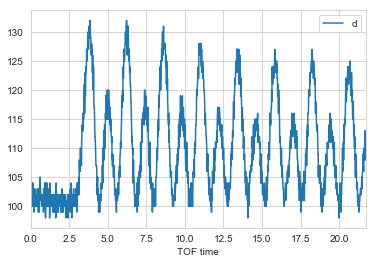

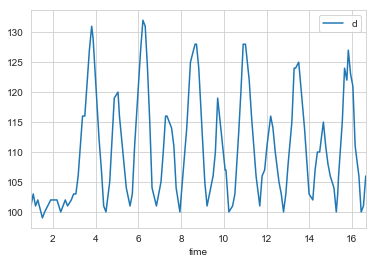

In [265]:
plt.tight_layout()
plt.figure(figsize=(12,16))
data.plot(y="d",x="TOF time")
df.plot(y='d', x='time') #df is now our merged, synced data frame

### Notice that our data now looks smoother (~100+ rows of data)
### In every experiment, at least the first 20 data points seem to be noise so let's remove it

# After merging and omitting first 20 rows of data

(96, 11)

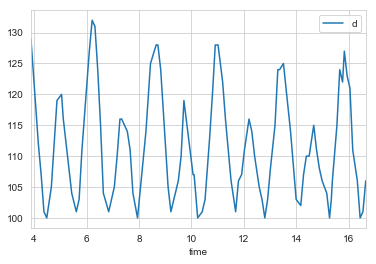

In [266]:
df = df.iloc[20:]
df.plot(y='d', x='time') #df is now our merged, synced data frame
df.shape

 Removing the first 20 data points looks good for Exp1. For other experiments that may be longer or shorter, we may need to adjust how much of of the initial data to truncate. I think 20% of each dataset should suffice

<br>


# Since I am now comfortable with fitting this data, let's utilize Scipy's curve_fitting library again.
Yesterday, I tried optimizing a fit with 3 types of test functions: <br>

- A generic sine func: a*sin(b*x)+c    <br>
 
- Dampened sine function: a*exp(-b*x)*sine(c*x)+d <br>

- A high degree polynomial (numpy's polyfit 1d lib) <br>

### Here are plots of what it looks like when I try to use scipy to fit an optimal dampened sine function to ALL of the data

Best parameters for a,b,c,d:  [1.60324603e+04 1.65949567e+00 6.67972882e+00 1.11683576e+02]
Std. of parameters:  [7.62541322e+04 1.12763257e+00 8.63462805e-02 8.98384235e-01]




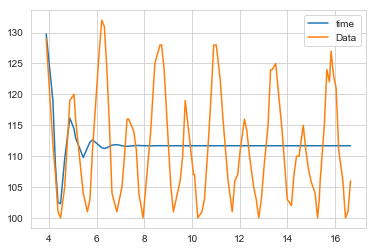

In [267]:
def test_func(x, a, b, c,d):
    return (a*np.exp(-b*x)*np.sin(c * x))+d

params, params_covariance = optimize.curve_fit(test_func, df['time'], df['d'], 
                                                   p0=[500, .001, 6.28, 110],maxfev=5000) 

print("Best parameters for a,b,c,d: ", params)
print("Std. of parameters: ", np.sqrt(np.diag(params_covariance)))
print("\n")
plt.plot(df['time'], test_func(df['time'], params[0], params[1], params[2], params[3]))
plt.plot(df['time'], df['d'], label='Data')
plt.legend(loc='best')

### It takes some good initial guesses to force scipy to pick proper parameters for our fit. 
- For experiment 1: p0=[-15, .001, 6.28, 110] fits most reasonably
- For experiment 2: p0=[.100, .001, 6.28, 110] fits most reasonably
- For experiment 3: large value for A fits better (500+)
- For experiment 4: large value for A fits better (500+)


 - Rebecca suggested that I fit each "period" or every 2 peaks with a test function. I think that the dampened sine motion or a gaussian curve might work for us.
To do this, we need a function that: <br>
1) extracts the indices of all existing local minimums. <br>
2) Slices our df into periods: df[index1 to index3], df[index3 to index5], df[index5 to index7] <br>
3) Iterate through each "period" -> fit each curve using some func; extract parameters and std.  <br>
4) With our best params in each period, plot the fits for each one respectively (OVER THE EXPERIMENTAL DATA) <br>

In [268]:
from scipy.signal import argrelextrema
from scipy.signal import find_peaks

df.reset_index()

dist_arr = df['d'].to_numpy()
minimums = argrelextrema(dist_arr, np.less)[0].tolist()
if (len(minimums) % 2) == 0:
    minimums = minimums[:-1]
mins = [minimums[i] for i in range(len(minimums)) if i % 2 == 0]
print(mins)

[4, 19, 36, 54, 72, 87]


- These are the indexes corresponding to pairs of local minimum in our dataset. <br>
- We can use these to slice our dataset into periods
- Note that if we have even number of minimums, we need to remove the last one.
- We also want only even-indiced minimums, as these represent 1 period

# Let's plot these minimums to make sure they look okay (They dont...)

[100.0, 101.0, 101.0, 101.0, 102.0, 122.0]
[4.483, 6.845, 9.217, 11.686, 14.168, 15.763]


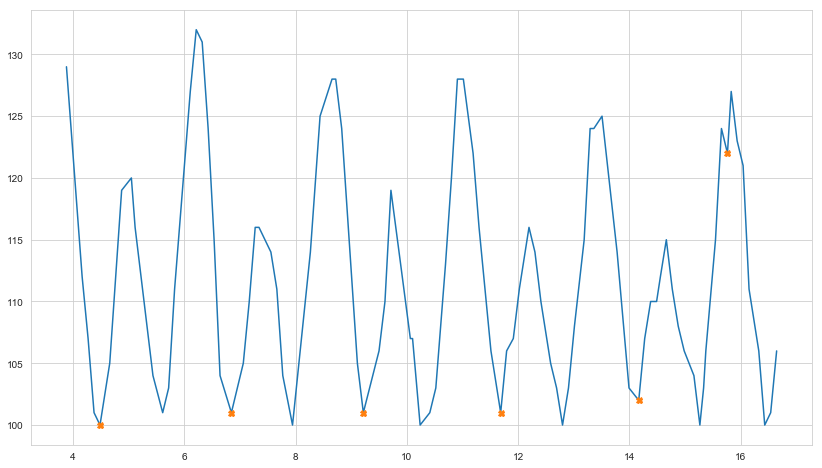

In [269]:
min_times = []
min_distances = []
for n in mins:
    min_distances.append(df['d'].iloc[n]) #retrieves distance at each local minimum's index
    min_times.append(df['time'].iloc[n])
print(min_distances)
print(min_times)

plt.figure(figsize=(14, 8))
plt.plot(df['time'], df['d'], label='Data')
plt.plot(min_times, min_distances, "X")

- There is a big issue here: The script is finding EVERY local minimum which is good, but our data is not yet smooth enough. If our local minimums are not all correct, then scipy will not be able to find/apply an optimal fit for that period
- Experiment #4 for example, is unfittable due to an error: "Optimal parameters not found": 
    - We either need to refine our local minimum algorithm, or smooth the data so these minimums are easier to find
    - Smoothing the data may be easier

# Savgol Filter: Smoothing our cleaned, merged data for more acc. minimums 
- Some methods include: scipy's savgol filter, triangular moving average to generate more data points, and Savitzky-Golay Filter
- Reference: https://plotly.com/python/smoothing/
- Smoothing data may skew the representation of the data enough to change its percieved meaning, but it is imperative in our case. Also, since there is little to no small-scale structure in the data, smoothing is safe.

Length of data went from 96 to 96


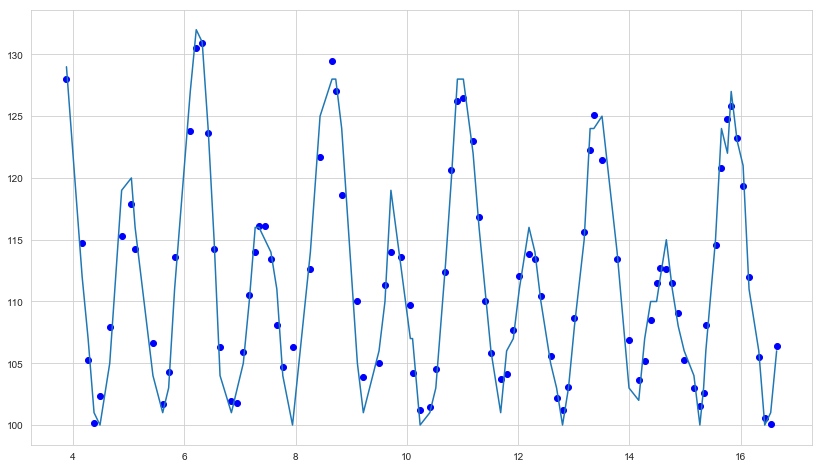

In [270]:
plt.figure(figsize=(14, 8))
savgol_dist =signal.savgol_filter(df['d'], 7, 3) # set to 37, 5 for exp 5
plt.plot(df['time'], savgol_dist,"bo",label='smoothing filter applied')
plt.plot(df['time'], df['d'], label='regular data')
print("Length of data went from", len(df['d']), "to", len(y))

# Let's see if the savgol filter gives us better local minimums

Indexes of every 2 local minimum at: [3, 20, 36, 54, 72, 94]
# Indexes: 6


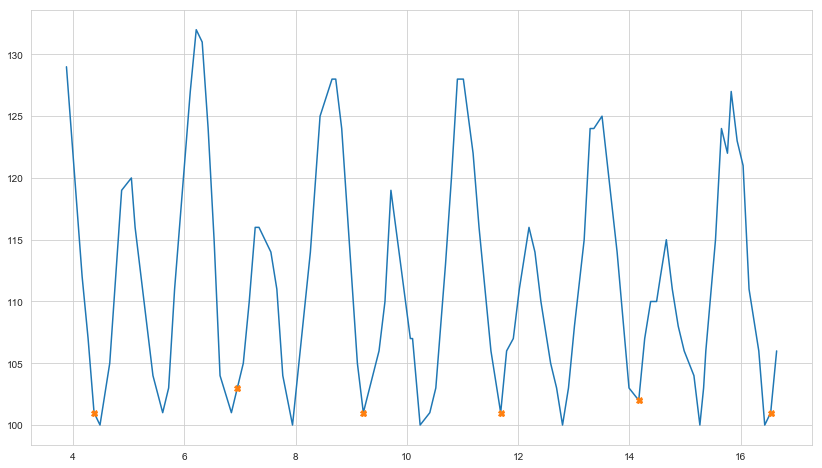

In [271]:
minimums = argrelextrema(savgol_dist, np.less)[0].tolist()
if (len(minimums) % 2) == 0:
    minimums = minimums[:-1]
mins = [minimums[i] for i in range(len(minimums)) if i % 2 == 0]
print("Indexes of every 2 local minimum at:", mins)
print("# Indexes:", len(mins))

min_times = []
min_distances = []
for n in mins:
    min_distances.append(df['d'].iloc[n]) #retrieves distance at each local minimum's index
    min_times.append(df['time'].iloc[n])

plt.figure(figsize=(14, 8))
plt.plot(df['time'], df['d'], label='Data')
plt.plot(min_times, min_distances, "X")

# This definitely looks better; we have plotted the indexes of every 2 minimums. 
- We can now use these filtered distances instead
- Hopefully, this will prevent scipy from getting confused when optimizing our test function

# Slicing our dataset into smaller, periodic sets 

In [272]:
partitioned_data = []
try:
    for i in range(len(mins)):
        partition = df.iloc[mins[i]:mins[i+1]+1]
        partitioned_data.append(partition)
        print("END OF PARTITION" + " " + str(i+1))
except IndexError as err:
    print("OS error: {0}".format(err))


END OF PARTITION 1
END OF PARTITION 2
END OF PARTITION 3
END OF PARTITION 4
END OF PARTITION 5
OS error: list index out of range


# Our data is now partitioned into periodic parts in our list "partitioned data"
### we can start applying curve fits to each individual set; two options: a Gaussian fit or a dampened oscillator equation 

In [197]:
### Let us define 2 different test functions so we can compare metrics later

def test_func(x, a, b, c,d):
    return (a*np.exp(-b*x)*np.sin(c * x))+d

def gauss_func(x, a, b, c, d):
    return a*np.exp(-np.power(x-b,2)/(2*np.power(c,2)))+d

# pars, cov = curve_fit
# stdevs = np.sqrt(np.diag(cov)) #std of the parameters
# res = y_exp -power_law(x_exp, *pars)

# 1) Test function: Dampened oscillator <br>
- We need to apply this fit on each partition and store the optimized parameters & std's.
- I am using the same initial guesses for the parameters as in my last week's notebook. 
- Hard part will be "Summing up this fit" for the whole data. Might run into some issues for this

Best parameters a,b,c,d for period 1 [ -5.09049555  -0.15907547   4.7791574  112.41473207]
Std. of parameters for period 1 [4.85005211 0.15786898 0.02497543 1.20106331]


Best parameters a,b,c,d for period 2 [-2.23000121e-02 -7.18279107e-01  6.40604441e+00  1.13206114e+02]
Std. of parameters for period 2 [0.09945536 0.51673674 0.03844405 1.83963908]


Best parameters a,b,c,d for period 3 [-1.63507210e+01  6.74369989e-02  6.18153481e+00  1.11734414e+02]
Std. of parameters for period 3 [8.47377158e+01 4.89721376e-01 2.86324254e-02 1.77558490e+00]


Best parameters a,b,c,d for period 4 [  0.15485154  -0.30015405   6.21759041 110.61557665]
Std. of parameters for period 4 [0.81653955 0.40204515 0.02096744 1.47658165]


Best parameters a,b,c,d for period 5 [-3.05534690e-04 -6.55419887e-01  6.24949783e+00  1.11612073e+02]
Std. of parameters for period 5 [0.00166239 0.34328729 0.01269289 1.19373654]


Average parameter: [ -4.26179412  -0.3530983    5.96676497 111.91658193]
Average std: [18.101

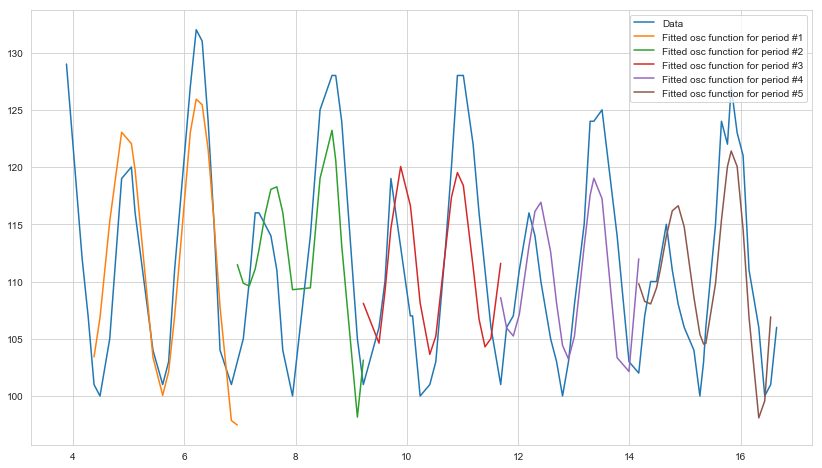

In [274]:
plt.figure(figsize=(14, 8))
plt.plot(df['time'], df['d'], label='Data')
period = 0
param_sum = 0
std_sum = 0

for dataset in partitioned_data:
    period+=1
    labeler = "Fitted osc function for period #" + str(period)
    params, params_covariance = optimize.curve_fit(test_func, dataset['time'], dataset['d'], 
                                                   p0=[-15, .001, 6.28, 110],maxfev=5000) 
    plt.plot(dataset['time'], test_func(dataset['time'], params[0], params[1], params[2], params[3]), label=labeler)

    plt.legend(loc='best')
    
    print("Best parameters a,b,c,d for period",(period), params)
    param_sum+=params
    print("Std. of parameters for period", (period),np.sqrt(np.diag(params_covariance)))
    std_sum+=np.sqrt(np.diag(params_covariance))
    print("\n")

print("Average parameter:", param_sum/len(partitioned_data))
print("Average std:", std_sum/len(partitioned_data))
plt.show()

# Overall, this looks much better than fitting over the whole dataset
### Smoothing our data with the savgol filter enabled this script to run without errors. We can see that a particular fit fails when standard deviation of parameters are infinity
- The output describes the best possible parameters for our test function <br>
- Period = 2pi/C, where c is the parameter inside our sin term. We can see the optimal values of C changing with each   period. Period is largest for the 1st oscillation <br>
- *Maybe rebecca could get something from this? <br>

# 2) Test function: Gaussian 

- Reference: Basic Curve Fitting of Scientific Data with Python (TowardsDataScience.com)
- We need to feed initial guesses to the function, or scipy struggles to pick the optimal parameters

[ 20.          -1.           1.         113.52173913]
[ 20.         -1.          1.        112.7826087]
[ 20.   -1.    1.  111.5]
[ 20.          -1.           1.         111.15384615]
[ 20.          -1.           1.         108.33333333]
[ 20.    -1.     1.   110.75]
[ 20.          -1.           1.         107.80952381]
[ 20.          -1.           1.         110.14285714]
[ 20.   -1.    1.  108.5]
[ 20.  -1.   1. 109.]
[ 20.    -1.     1.   109.12]
[ 20.          -1.           1.         109.69230769]
[ 20.   -1.    1.  109.5]
[ 20.      -1.       1.     109.3125]
[ 20.          -1.           1.         106.09090909]
[ 20.          -1.           1.         108.34782609]


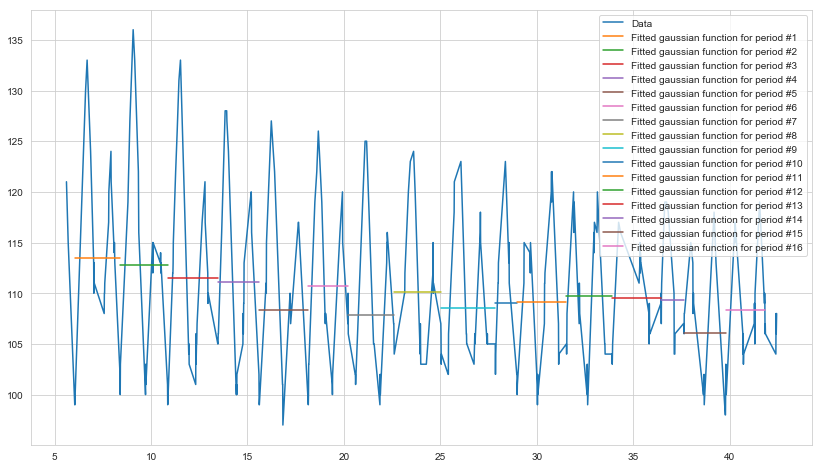

In [102]:
plt.figure(figsize=(14, 8))
plt.plot(df['time'], df['d'], label='Data')
period = 0

for dataset in partitioned_data:
    period+=1
    labeler = "Fitted gaussian function for period #" + str(period)
    params, params_covariance = optimize.curve_fit(gauss_func, dataset['time'], dataset['d'], 
                                                   p0=[20, -1, 1, 110], maxfev=5000) 
    plt.plot(dataset['time'], gauss_func(dataset['time'], params[0], params[1], params[2], params[3]), label=labeler)

    plt.legend(loc='best')
    
    print(params)
    
plt.show()

- I am struggling to fit a gaussian peak the data. I will stick to our 1st curve fit for the rest of analysis

# Summary of experiments

In [261]:
summary_df = pd.DataFrame(columns=['Exp #', 'Length of data', 'Length of cleaned data', 
                                   'Best Parameters for entire fit', 'Std of parameters', 'savgol windows','# of Periods',
                                   'Average best parameters', 'Average std of parameters'])

summary_df.at[1, 'Exp #'] = 1
summary_df.at[1, 'Length of data'] = 1627
summary_df.at[1, 'Length of cleaned data'] = 96
summary_df.at[1, 'Best Parameters for entire fit'] = [1.602e+04, 1.659e+00, 6.680e+00, 1.117e+02]
summary_df.at[1, 'savgol windows'] = 7   #Important for locating the minimums accurately
summary_df.at[1, 'Std of parameters'] = [7.589e+04, 1.127e+00, 8.634e-02, 8.984e-01]
summary_df.at[1, '# of Periods'] = 5
summary_df.at[1, 'Average best parameters'] = [ -4.262,  -0.353,    5.97, 111.917]
summary_df.at[1, 'Average std of parameters'] = [18.101,  0.382,  0.0251,  1.497]


summary_df.at[2, 'Exp #'] = 2
summary_df.at[2, 'Length of data'] = 3240
summary_df.at[2, 'Length of cleaned data'] = 309
summary_df.at[2, 'Best Parameters for entire fit'] = [-3.375e+00,  6.096e-02,  5.927e+00,  1.106e+02]
summary_df.at[2, 'savgol windows'] = 15
summary_df.at[2, 'Std of parameters'] = [2.371, 0.06702871, 0.0397, 0.493]
summary_df.at[2, '# of Periods'] = 9
summary_df.at[2, 'Average best parameters'] = [8.512e+07, 2.371e+01, 3.787e+00, 1.111e+02]
summary_df.at[2, 'Average std of parameters'] = "infinity"


summary_df.at[3, 'Exp #'] = 3
summary_df.at[3, 'Length of data'] = 3774
summary_df.at[3, 'Length of cleaned data'] = 282
summary_df.at[3, 'Best Parameters for entire fit'] = [-3.394e-01, -3.387e-02,  6.191e+00,  1.107e+02]
summary_df.at[3, 'savgol windows'] = 7
summary_df.at[3, 'Std of parameters'] = [1.258, 0.152, 0.0484, 0.556]
summary_df.at[3, '# of Periods'] = 14
summary_df.at[3, 'Average best parameters'] = [4.23e+12, 1.914e+01, 4.0642e+00, 1.108e+02]
summary_df.at[3, 'Average std of parameters'] = "infinity"

summary_df.at[4, 'Exp #'] = 4
summary_df.at[4, 'Length of data'] = 4082
summary_df.at[4, 'Length of cleaned data'] = 338
summary_df.at[4, 'Best Parameters for entire fit'] = [-8.171e+02,  6.315e-01,  6.238e+00,  1.090e+02]
summary_df.at[4, 'savgol windows'] = 7
summary_df.at[4, 'Std of parameters'] = [1.270e+03, 2.300e-01, 2.645e-02, 4.143e-01]
summary_df.at[4, '# of Periods'] = 20
summary_df.at[4, 'Average best parameters'] = [7.946e+08, 1.555e+01, 6.213e+00, 1.100e+02]
summary_df.at[4, 'Average std of parameters'] = "infinity"

summary_df

,Exp #,Length of data,Length of cleaned data,Best Parameters for entire fit,Std of parameters,savgol windows,# of Periods,Average best parameters,Average std of parameters
1,1,1627,96,"[16020.0, 1.659, 6.68, 111.7]","[75890.0, 1.127, 0.08634, 0.8984]",7,5,"[-4.262, -0.353, 5.97, 111.917]","[18.101, 0.382, 0.0251, 1.497]"
2,2,3240,309,"[-3.375, 0.06096, 5.927, 110.6]","[2.371, 0.06702871, 0.0397, 0.493]",15,9,"[85120000.0, 23.71, 3.787, 111.1]",infinity
3,3,3774,282,"[-0.3394, -0.03387, 6.191, 110.7]","[1.258, 0.152, 0.0484, 0.556]",7,14,"[4230000000000.0, 19.14, 4.0642, 110.8]",infinity
4,4,4082,338,"[-817.1, 0.6315, 6.238, 109.0]","[1270.0, 0.23, 0.02645, 0.4143]",7,20,"[794600000.0, 15.55, 6.213, 110.0]",infinity


# Conclusion <br>
- Experiment 5 encounters runtime error: this is likely due to overfitting/overcounting
- Each experiment requires its own initial guess of parameters for scipy to fit nice curves to our data 
- One big issue with this script is the partioning:
    - If we miscount the local minimums, scipy will start fitting garbage for these inaccurate periods.
    - This brings me back to square 1: It would be better to fit the behavior of the entire graph. There are so many       complications that arise with this method of curve fitting. 
- Our smoothing function can affect different datasets in different ways:
    - In order to accurately locate the minimums, we use a filter to smooth out our data. When we do this, we             set the filter's parameter "window" to an integer value. This value can drastically affect the performance of         our minimum peak finder, and ultimately, our curve fitter
    - The size of the dataset can also affect the performance of our peak finder.
- Honestly, fitting our function over the experiment doesn't look too bad for some experiments. Fitting periodic can look nasty for experiments 2-5

    